In [10]:
import h5py
import numpy as np
import tensorflow as tf
from transformers import TFSwinModel
import datetime
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.18.1


In [4]:
with h5py.File('/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5', 'r') as f:
    images = f['images'][:]  # shape: (N, 224, 224)
    layer_maps = f['layer_maps'][:]  # shape: (N, 224, 2) or (N, 224, 3)

In [6]:
images.shape, layer_maps.shape

((5088, 224, 224), (5088, 224, 3))

In [7]:
# add another dimension to images for compatibility
if images.ndim == 3:
    images = np.expand_dims(images, axis=-1)

# We only want ILM and BM (first and last columns) for training
layer_maps = layer_maps[:, :, [0, 2]]  # if shape is (N, 224, 3)

In [8]:
images.shape, layer_maps.shape

((5088, 224, 224, 1), (5088, 224, 2))

In [11]:
images = images[:1000]
layer_maps = layer_maps[:1000]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    images, layer_maps, test_size=0.2, random_state=42
)

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16).shuffle(100)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)

## CNN with a regression head

In [34]:
# Create a simple CNN model for layer annotation prediction
def create_layer_annotation_model():
    input_layer = tf.keras.layers.Input(shape=(224, 224, 1))
    
    # CNN backbone
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    # Global average pooling to get feature vector
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Dense layers for regression
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer: predict 224 points for 2 layers (ILM and BM)
    x = tf.keras.layers.Dense(224 * 2, activation='linear')(x)
    output = tf.keras.layers.Reshape((224, 2))(x)
    
    return tf.keras.Model(inputs=input_layer, outputs=output)

# Create and compile model
model = create_layer_annotation_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print("Model created successfully!")
print(f"Input shape: (224, 224, 1)")
print(f"Output shape: (224, 2)")
model.summary()

Model created successfully!
Input shape: (224, 224, 1)
Output shape: (224, 2)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                               

In [35]:
# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [36]:
# Train model
model.fit(train_dataset,
          validation_data=test_dataset, 
          epochs=10, 
          callbacks=[tensorboard_callback])

Epoch 1/10
50/50 [==============================] - 4s 43ms/step - loss: 0.1955 - mean_absolute_error: 0.3667 - val_loss: 0.0515 - val_mean_absolute_error: 0.1663
Epoch 2/10
50/50 [==============================] - 4s 43ms/step - loss: 0.1955 - mean_absolute_error: 0.3667 - val_loss: 0.0515 - val_mean_absolute_error: 0.1663
Epoch 2/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0274 - mean_absolute_error: 0.1242 - val_loss: 0.0055 - val_mean_absolute_error: 0.0569
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0274 - mean_absolute_error: 0.1242 - val_loss: 0.0055 - val_mean_absolute_error: 0.0569
Epoch 3/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0109 - mean_absolute_error: 0.0828 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.0109 - mean_absolute_error: 0.0828 - val_loss: 0.0037 - val_mean_absolute_error: 0.0471
Epoch 4/10
50/50 [====

In [37]:
# Evaluate model
test_loss = model.evaluate(test_dataset)
print(f"Test MSE: {test_loss}")

13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0375
Test MSE: [0.0023761724587529898, 0.037492867559194565]
13/13 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_absolute_error: 0.0375
Test MSE: [0.0023761724587529898, 0.037492867559194565]


In [38]:
#To save the model
model.save('CNN_regression_model.h5')

#TO load the model later
model = tf.keras.models.load_model('CNN_regression_model.h5')
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       7385

/home/suraj/anaconda3/envs/vision-2/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step


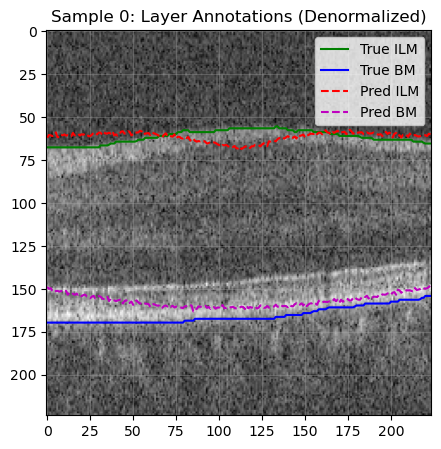

1/1 [==============================] - 0s 17ms/step


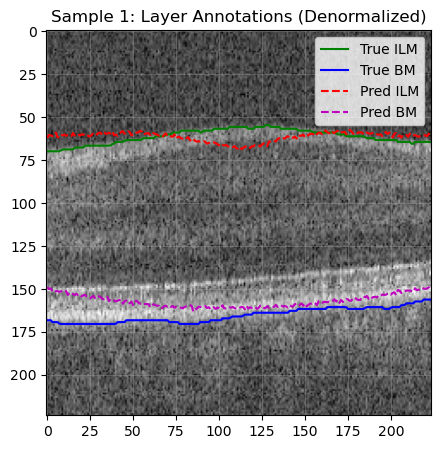

1/1 [==============================] - 0s 17ms/step


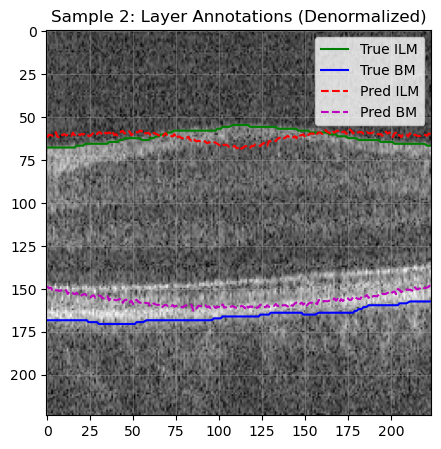

1/1 [==============================] - 0s 16ms/step


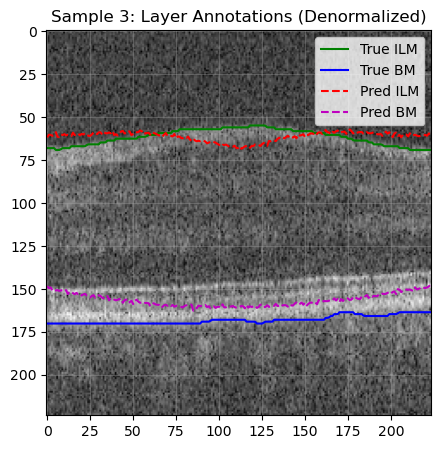

1/1 [==============================] - 0s 16ms/step


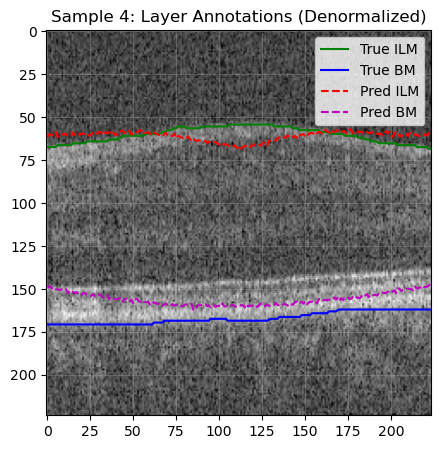

In [43]:
# Replace these with your actual min and max values used for normalization
layer_min = 0  # e.g., 0
layer_max = 224  # e.g., 224

def denormalize_layers(layers, layer_min, layer_max):
    return layers * (layer_max - layer_min) + layer_min

def plot_layer_annotations(model, images, layer_maps, num_samples=5):
    for idx in range(num_samples):
        img = images[idx]
        true_layers = denormalize_layers(layer_maps[idx], layer_min, layer_max)
        pred_layers = denormalize_layers(model.predict(img[np.newaxis, ...])[0], layer_min, layer_max)

        plt.figure(figsize=(8, 5))
        plt.imshow(img[:, :, 0], cmap='gray')
        plt.plot(range(224), true_layers[:, 0], 'g-', label='True ILM')
        plt.plot(range(224), true_layers[:, 1], 'b-', label='True BM')
        plt.plot(range(224), pred_layers[:, 0], 'r--', label='Pred ILM')
        plt.plot(range(224), pred_layers[:, 1], 'm--', label='Pred BM')
        plt.title(f"Sample {idx}: Layer Annotations (Denormalized)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Example usage:
plot_layer_annotations(model, images, layer_maps, num_samples=5)